# Лабораторная работа 8. Динамическое программирование.

In [1]:
import pylab
import numpy as np
import time
import matplotlib.pyplot as plt

# Пример №1. Числа Фибоначчи

Последовательность чисел Фибоначчи задаётся рекуррентным выражением:

$$ F_n =  \begin{cases}
           0, n = 0, \\
           1, n = 1, \\
           F_{n-1}+F_{n-2}, n > 1.
          \end{cases} $$

Оно даёт следующую последовательность: {0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …}.

Один из способов решения, который может показаться логичным и эффективным, — решение с помощью рекурсии:

In [2]:
def Fibonacci_Recursion(n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return Fibonacci_Recursion (n-1) + Fibonacci_Recursion (n-2)

Используя такую функцию, мы будем решать задачу «с конца» — будем шаг за шагом уменьшать `n`, пока не дойдем до известных значений.

Но, как мы видели ранее, эта реализация многократно повторяет решение одних и тех же задач. Это связано с тем, что одни и те же промежуточные данные вычисляются по несколько раз, а число операций нарастает с той же скоростью, с какой растут числа Фибоначчи — экспоненциально.

Один из выходов из данной ситуации — сохранение уже найденных промежуточных результатов с целью их повторного использования (кеширование). Причём кеш должен храниться во внешней области памяти.

In [6]:
def Fibonacci_Recursion_cache(n, cache):
    if n == 0:
        return 0
    if n == 1:
        return 1
    if cache[n] > 0:
        return cache[n]
    cache[n] = Fibonacci_Recursion_cache(n - 1, cache) + Fibonacci_Recursion_cache(n - 2, cache)
    return cache[n]

Приведенное решение достаточно эффективно (за исключением накладных расходов на вызов функций). Но можно поступить ещё проще:

In [4]:
def Fibonacci(n):
    fib = [0] * max(2, n)
    fib[0] = 1
    fib[1] = 1
    for i in range(2, n):
        fib[i] = fib[i - 1] + fib[i - 2]
    return fib[n-1]

Такое решение можно назвать решением «с начала»: мы первым делом заполняем известные значения, затем находим первое неизвестное значение, потом следующее и т.д., пока не дойдем до нужного.

Так и работает динамическое программирование: сначала решили все подзадачи (нашли все `F[i]` для `i < n`), затем, зная решения подзадач, нашли решение исходной задачи.

Проверим правильность работы этих программ:

In [7]:
N = 9
cache = [0] * (N + 1)
assert Fibonacci_Recursion(N) == 34
assert Fibonacci_Recursion_cache(N, cache) == 34
assert Fibonacci(N) == 34

И их производительность:

In [8]:
n = 25
a = np.zeros(n)
cache = [0] * (n + 1)

In [9]:
start_time = time.time()
for i in range (n): a[i] = Fibonacci_Recursion(i)
print('%-28s %12.6e sec' % ('Fibonacci_Recursion:', time.time()-start_time))

start_time = time.time()
for i in range (n): 
    cache = [0]*(i+1)
    a[i] = Fibonacci_Recursion_cache(i,cache)
print('%-28s %12.6e sec' % ('Fibonacci_Recursion_cache:', time.time()-start_time))
    
start_time = time.time()
for i in range (n): a[i] = Fibonacci(i)
print('%-28s %12.6e sec' % ('Fibonacci:', time.time()-start_time))

Fibonacci_Recursion:         2.153654e-01 sec
Fibonacci_Recursion_cache:   7.236004e-04 sec
Fibonacci:                   4.487038e-04 sec


# Пример №2. Задача о возрастающей подпоследовательности

Пусть имеется последовательность чисел $a_1, a_2, … a_N$. Подпоследовательность $a_{i_1}, a_{i_2}, a_{i_3}$, ... называется возрастающей, если:

$$ 1 < i_1 < i_2 < ... < i_k < n $$

и:

$$ a_{i_1} < a_{i_2} < ... < a_{i_k} $$

Требуется найти максимальную длину возрастающей подпоследовательности. Например, для последовательности $a_i = {10, 4, 13, 7, 3, 6, 17, 33}$ одна из возрастающих подпоследовательностей — ${4, 7, 17, 33}$.

В этой задаче длина наибольшего пути к вершине `i` (уравнение Беллмана) есть максимум из наибольших путей к предыдущим вершинам плюс единица:

$$ L_i = 1 + max(L_{i-1, j}, j = 1, N_{L_{i-1}}).$$

In [10]:
def f(a, k):
    # k - номер конечного элемента
    m = 0
    for i in range(k):      # для всех слева
        if (a[i] < a[k]):   # есть путь?
            p = f(a,i)      # его длина
            if (p > m): m = p   # m = max(m,p)
    return m + 1

In [11]:
a = [1, 4, 2, 5, 3]
f(a, 3)

3

Чтобы повторно не решать решённые подзадачи, введём массив c размером `N`, хранящий значения вычисленных функций. Начальные значения его равны нулю — значению, которое не может быть верным решением любой из подзадач. Это позволит нам определить, решали ли мы эту подзадачу или нет. Если нет — запускаем решение для требуемого аргумента, и после получения результата сохраняем его.

In [12]:
def f(a, N, k, cache):
    # k - номер конечного элемента
    if cache[k] != 0: return cache[k]
    m = 0
    for i in range(k - 1):          # для всех слева
        if (a[i] < a[k]):           # есть путь?
            p = f(a, N, i, cache)   # его длина
            if p > m: m = p           # m = max(m,p)
    cache[k] = m + 1
    return cache[k]

In [13]:
c = [0] * 5
a = [1, 4, 2, 5, 3]
f(a, 5, 4, c)

3

# Пример №3. Задача о банкомате

Если в задаче о рюкзаке сделать варианты предметов неисчерпаемыми, можно перейти к задаче о банкомате.

**Постановка:** в банкомате имеется неограниченное количество банкнот (`b1`, `b2`, ... , `bn`) заданных номиналов. Нужно выдать требуемую сумму денег наименьшим количеством банкнот.

Как мы уже выяснили, жадное решение возможно не для всех наборов входных данных. Например, при `b = {1, 6, 10}` и `x = 12` жадное решение даст ответ 3 `(10 + 1 + 1)`, хотя существует более оптимальное решение 2 `(6 + 6)`. 
Сделаем задачу о банкомате похожей на задачу о количестве маршрутов.

Для каждой суммы проведём стрелку к узлу с новой разрешённой суммой. Уравнение Беллмана:

$$ f(x) =  \begin{cases}
            min(f(x-b_i))+1, x > 0 \\
            \quad 0 \quad, x = 0 \\
            \quad \infty \quad, x < 0
           \end{cases} $$

In [15]:
bigBoy = 999999999
def f(x, b, n, cache):
    if x < 0: return bigBoy
    elif x == 0: return 0
    elif cache[x] >= 0: return cache[x]
    minim = bigBoy
    for i in range(n):
        r = f(x - b[i], b, n, cache)
        if r < minim: minim = r
    cache[x] = minim + 1
    return cache[x]

In [16]:
cache = [-1] * 10
b = [1, 4, 6]
f(9, b, 3, cache)

3

Доведя решение задачи до ответа и получив кэш-таблицу, можно восстановить решение без дополнительной информации.
Предположим, что мы знаем, что точный ответ при заданных начальных значениях есть `7`. Тогда возникает вопрос: какой предыдущий ход мы сделали, чтобы попасть в заключительную позицию? 

Введём термин *ранг* для обозначения наименьшего числа ходов, требуемого для достижения текущей позиции из начальной. Тогда каждый ход решения всегда переходит в позицию с рангом, большим строго на единицу, и это позволяет нам придумать следующий алгоритм:

1. решение основной задачи дало в ответе `k`, это — ранг заключительной позиции,
2. делаем позицию текущей,
3. если текущая позиция имеет ранг `0`, то это — начальная позиция и алгоритм завершён,
4. рассматриваем позиции, ведущие в текущую, и выбираем из них произвольную с рангом `k − 1`,
5. запоминаем ход, который привёл из позиции ранга `k − 1` в ранг `k`,
6. понижаем ранг – `k → k − 1` и переходим к (2).

In [17]:
def buildSolution(x, b, n, cache):
    ret = []
    for k in range (cache[x], -1, -1):
        for i in range(n):
            r = x - b[i]
            if (r >= 0 and cache[r] == k - 1):
                x = r
                ret.append(b[i])
                break
    return ret

In [18]:
buildSolution(9, b, 3, cache)

[1, 4, 4]

# Пример №4. Задача о кузнечике.

Рассмотрим следующую задачу. На числовой прямой сидит кузнечик, который может прыгать вправо на одну или на две единицы. Первоначально кузнечик находится в точке с координатой `1`. Определите количество различных маршрутов кузнечика, приводящих его в точку с координатой `n`.

Обозначим количество маршрутов кузнечика, ведущих в точку с координатой `n`, как `K[n]`. Прежде всего заметим, что существует ровно один маршрут из точки `1` в точку `1` — он не содержит ни одного прыжка. В точку `2` можно прыгнуть единственным способом — из точки `1`.

Как вычислить `K[n]`? В точку кузнечик может попасть двумя способами — из точки при помощи прыжка длиной `2` и из точки прыжком длины `1`. То есть число способов попасть в точку `n` равно сумме числа способов попасть в точку `(n - 1)` и `(n - 2)`, что позволяет выписать рекуррентное соотношение: 

$$K[n] = K[n-1] + K[n-2].$$

Можно заметить, что данная задача по сути свелась к числам Фибоначчи, поэтому мы не будем выписывать её решение.

# Упражнение №1

Решите задачу о количестве способов достичь точки `n` из точки `1`, если кузнечик умеет прыгать `+1`, `+2` и `+3`.

In [19]:
def grasshopper(n):
    GH = [0] * max(3, n)
    GH[0] = 0 # уже в первой точке
    GH[1] = 1
    GH[2] = 2
    for i in range(3, n):
        GH[i] = GH[i - 1] + GH[i - 2] + GH[i - 3]
    return GH[n - 1]

In [20]:
grasshopper(5)

6

# Упражнение №2. Задача о кузнечике с ценой посещения точек

Пусть кузнечик прыгает на одну или две точки вперед, а за прыжок в каждую точку необходимо заплатить определенную стоимость, различную для различных точек. Стоимость прыжка в точку `i` задается значением `price[i]` списка `price`. Необходимо найти минимальную стоимость маршрута кузнечика из точки `0` в точку `n`.

На этот раз нам необходимо модифицировать определение целевой функции. Пусть `C[n]` — минимальная стоимость пути из `1` в `n`.

Выведем рекуррентное соотношение для этой функции.Чтобы попасть в точку n мы должны попасть в неё последним прыжком из `(n - 1)` или `(n - 2)`. Минимальные стоимости этих маршрутов будут равны `С[n - 1]` и `С[n - 2]` соответственно, к ним придется добавить значение `price[n]` за прыжок в клетку `n`. Но из двух клеток мы можем выбрать любую.

Нужно выбрать тот маршрут, который имеет наименьшую стоимость (ниже приведено уравнение Беллмана): 

$$C[n] = min(C[n-1], C[n-2]) + price[n].$$

Вычислять значение целевой функции также лучше при помощи динамического программирования, а не рекурсии.

Напишите функцию вычисления наименьшей стоимости достижения клетки `n` из клетки `1`.

In [21]:
def grasshopperWithCost(n, prices):
    if len(prices) < 2:
        return
    costs = [0] * max(2, n + 1)
    costs[0] = 0
    costs[1] = prices[0]
    for i in range(2, n + 1):
        costs[i] = min(costs[i - 1], costs[i - 2]) + prices[i - 1]
    return costs[n]

In [22]:
prices = list(map(float, input('Введите через пробел стоимости попадания в точки 2 - N: ').split()))

Введите через пробел стоимости попадания в точки 2 - N: 5 7 73 2 18 79


In [23]:
try:
    k = int(input('Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: ')) - 1
    if not 1 <= k < len(prices) + 1:
        print('Не назначена стоимость пути до точки.')
    else:
        print('Стоимость пути равна', grasshopperWithCost(k, prices))
except:
    print('Точка должна быть обозначена целым числом от 1 до N.')

Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: 4
Стоимость пути равна 78.0


# Упражнение №3. Восстановление наиболее выгодной траектории
Итак, мы нашли список `С`, где будет записана минимальная стоимость маршрута для всех точек от `1` до `n`.

Но помимо нахождения наименьшей стоимости маршрута, разумеется, хотелось бы найти и сам маршрут минимальной стоимости. Такая задача называется задачей «восстановления ответа».

Для восстановления ответа будем для каждой точки запоминать номер точки `prev[i]`, из которой кузнечик попал в точку `i`, если он будет передвигаться по пути минимальной стоимости. Таким образом, `prev[i]` — это точка, предшествующая точке с номером `i` на пути минимальной стоимости (также говорят, что `prev` — это массив предшественников). Как определить `prev[i]`? Если `C[i - 1] < C[i - 2]`, то кузнечик попал в точку `i` из точки `(i - 1)`, поэтому `prev[i] = i - 1`, иначе `prev[i] = i - 2`.

Для восстановления пути необходимо начать с точки `n` и переходить от каждой точки к ее предшественнику, пока путь не дойдет до начальной точки с номером `0`. Номера всех вершин будем добавлять в список `path`. В конце в список `path` добавляется начальная вершина номер `1`, которая не была обработана в основном цикле, а затем весь список `path` разворачивается в обратном порядке (т.к. вершины добавляются в обратном порядке, от конечной к начальной).

Модифицируйте алгоритм вычисления значений целевой функции так, чтобы вычислить значения `prev[i]`, и восстановите траекторию наименьшей стоимости из точки `1` в точку `n`.

In [24]:
# программа немного не соответствует описанию, но, тем не менее, успешно решает задачу
def grasshopperWithCostAndPath(n, prices):
    if len(prices) < 2:
        print('')
        return
    if n == 1:
        return 0, []
    elif n == 2:
        return prices[0], [1]
    paths = []
    costs = [0] * max(2, n + 1)
    costs[0] = 0
    costs[1] = prices[0]
    paths.append([])
    paths.append([1])
    for i in range(2, n):
        if costs[i - 1] >= costs[i - 2]:
            costs[i] = costs[i - 2] + prices[i - 1]
            paths.append(paths[i - 2] + [i - 1])
        else:
            costs[i] = costs[i - 1] + prices[i - 1]
            paths.append(paths[i - 1] + [i])
    return costs[n - 1], paths[n - 1]

In [25]:
prices = list(map(float, input('Введите через пробел стоимости попадания в точки 2 - N: ').split()))

Введите через пробел стоимости попадания в точки 2 - N: 5 7 73 2 4 5 9


In [26]:
try:
    k = int(input('Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: '))
    if not 0 < k <= len(prices) + 1:
        print('Не назначена стоимость пути до точки.')
    else:
        cost, path = grasshopperWithCostAndPath(k, prices)
        print('Стоимость пути равна ' + str(cost) + '.')
        print('Путь: ', end='')
        for i in range(len(path)):
            print(path[i], end=' -> ')
        print(k)
except:
    print('Точка должна быть обозначена целым числом от 1 до N.')

Введите точку, в которую нужно рассчитать маршрут минимальной стоимости: 8
Стоимость пути равна 22.0.
Путь: 1 -> 3 -> 5 -> 6 -> 8


In [27]:
def onlyPathDefinderForOptimalCost(dot, prices):
    # по условию путь оптимален, так как его стоимость минимальна
    prices = [0] + prices
    price = prices[dot]
    while dot > 1:
        if prices[dot - 1] >= prices[dot - 2]:
            price += prices[dot - 2]
            dot -= 2
        else:
            price += prices[dot - 1]
            dot -= 1
    return price

In [28]:
print('Стоимость пути равна:', 
      onlyPathDefinderForOptimalCost(int(input('Введите точку, из которой хотите ' +
                                               'рассчитать оптимальную стоимость: ')) - 1, prices))

Введите точку, из которой хотите рассчитать оптимальную стоимость: 8
Стоимость пути равна: 22.0


# Пример №5. Расстояние редактирования

Часто текстовый редактор, подозревая опечатку, предлагает заменить написанное слово на близкое. Что значит «близкое»? 

Количество операций для превращения одного слова в другое называется расстоянием редактирования или расстоянием Левенштейна (ИПМ им. Келдыша). Это расстояние — мера различия между двумя строками. Этой мерой измеряют сходство или различие двух генных последовательностей и т.д.
Задача. Определить минимальное количество операций для преобразования одного слова в другое, при следующих допустимых операциях:
- замена одной буквы на другую;
- вставка одной буквы;
- удаление одной буквы.

Например, сколько нужно операций, чтобы превратить слово `СЛОН` в слово `ОГОНЬ`? Например, это можно сделать следующей последовательностью:

`СЛОН → СГОН → СГОНЬ → ОГОНЬ`.

Последовательность переходов, которую мы описали, не обладает нужными свойствами (последовательным увеличением сложности задачи). А есть ли нужная нам последовательность, в которой каждая подзадача решается на подстроке всё более возрастающей длины? Конечно:

1. В префиксах строк длины 1 меняем букву `С` на `О`. `СЛОН → ОЛОН`.
2. В префиксах длины 2 меняем `Л` на `Г`. `ОЛОН → ОГОН`.
3. В префиксах длины 4 добавляем букву `Ь`. `ОГОН → ОГОНЬ`.

Итак, необходимо найти расстояние редактирования между $x[1...m]$ и $y[1...n]$. Будем искать расстояние редактирования между префиксами первой строки, $x[1...i]$, и префиксами второй, $y[1...j]$, обозначив эти расстояния $E[i,j]$. Конечная цель – вычисление $E[m, n]$.

Например, $E[7,5]$:
$$ \fbox{E X P O N E N} T I A L $$
$$ \fbox{P O L Y N} O M I A L $$

Значения $E[i,j]$ удобно представлять в виде таблицы. Для удобства добавим один лишний левый столбеци одну лишнюю верхнюю строку к этой таблице. Заполним их последовательно возрастающими числами. Эти числа означают, что пустая строка может превратиться в образец за число операций, равное длине образца. 

Очевидно, что при такой записи в каждуюследующую клетку можно попасть только из левой, верхне или по диагонали из левой верхне. При этом из этих вариантов выбирается минимальный и к нему прибавляются затраты на новое редактирование: 0 - если на пересечении текущего столбца и строки стоят одинаковые буквы и 1 - если разные. Т.е. ур. Беллмана:

$$ E[i,j] = min(1 + E[i-1, j], 1 + E[i, j-1], d(i, j) + E[i-1, j-1]), $$
$$ d(i, j) = \begin{cases}
                 0, x[i] = y[j] \\
                 1, x[i] \neq y[j]
                 \end{cases} $$

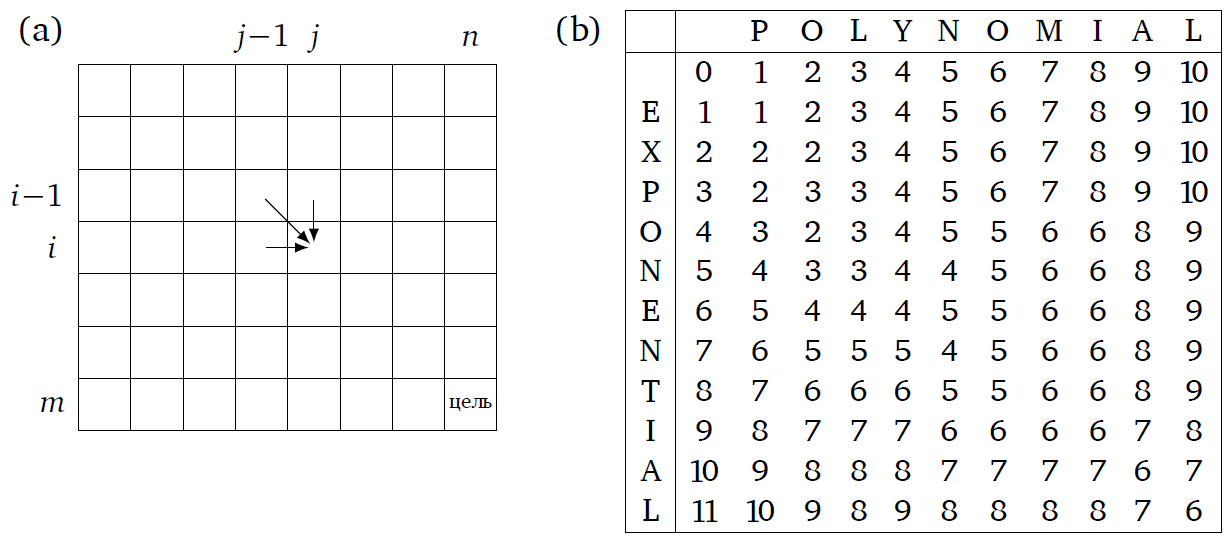

In [51]:
# Так можно добавлять картинки

from IPython.display import Image             # вызов из библиотеки определённой функции
Image("Расстояние редактирования.png")        # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

# Упражнение №4.

Напишите программу, вычисляющую расстояние редактирования.

In [29]:
def IDONTKNOWWHATISTHISBUTIMAFRAIDOFTHISBULLSHIT(first, second):
    E = np.zeros((len(first) + 1, len(second) + 1))
    # начальное заполнение матрицы
    for i in range(1, len(first) + 1):
        E[i][0] = i
    for j in range(1, len(second) + 1):
        E[0][j] = j
    for j in range(1, len(second) + 1):
        for i in range(1, len(first) + 1):
            E[i][j] = min(1 + E[i - 1][j],
                          1 + E[i][j - 1],
                          int(not first[i - 1] == second[j - 1]) + E[i - 1][j - 1])
    print(E)
    return E[len(first)][len(second)]

In [30]:
print(IDONTKNOWWHATISTHISBUTIMAFRAIDOFTHISBULLSHIT('фонарь', 'улица'))

[[0. 1. 2. 3. 4. 5.]
 [1. 1. 2. 3. 4. 5.]
 [2. 2. 2. 3. 4. 5.]
 [3. 3. 3. 3. 4. 5.]
 [4. 4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6.]]
6.0


# Домашнее задание (базовое):

# Задание №1. Гиперкузнечик.

Решите задачу о количестве способов достичь точки `n` из точки `1`, если кузнечик умеет прыгать `+1`, `+2` и `*3`.

In [31]:
def HYPERgrasshopper(n):
    GH = [None] + ([0] * max(3, n))
    GH[1] = 1
    GH[2] = 1
    for i in range(3, n + 1):
        GH[i] = GH[i - 1] + GH[i - 2]
        if i % 3 == 0:
            GH[i] += GH[i // 3]
    return GH[n]

In [32]:
print('Количество способов достичь её:',
      HYPERgrasshopper(int(input('Введите конечную точку: '))))

Введите конечную точку: 16
Количество способов достичь её: 1543


# Задание №2. Наибольшая общая подпоследовательность.

Рассмотрим две строки (или числовые последовательности) `A` и `B`. Пусть первая строка состоит из n символов $a_0, ... a_n$, вторая строка состоит из m символов $b_0, ..., b_m$. Подпоследовательностью данной строки (последовательности) называется некоторое подмножество символов исходной строки, следующих в том же порядке, в котором они идут в исходной строке, но не обязательно подряд. Если в строке n символов, то у нее $2^n$ различных подпоследовательностей: каждый из n символов строки может либо входить, либо не входить в любую выбранную подпоследовательность. Пустая подпоследовательность не содержит ни одного элемента и также является подпоследовательностью любой строки.

Рассмотрим задачу: для двух данных строк найти такую строку наибольшей длины, которая была бы подпоследовательностью каждой из них. Например, если `A = 'abcabaac'`, `B = 'baccbca'`, то у строк `A` и `B` есть общая подпоследовательность длины 4, например, `'acba'` или `'acbc'`.

Данную задачу можно решить перебором, например, перебрав все $2^n$ подпоследовательностей первой строки и для каждой их них проверив, является ли она подпоследовательностью второй строки. Но при помощи динамического программирования эту же задачу можно решить за сложность $O(n \cdot m)$.

Напишите программу, решающую данную задачу с помощью алгоритма, полученного на основе динамического программирования.

In [33]:
# метод не динамического программирования
def maxCommonSequence(first, second):
    commonSequences = []
    i = 0
    while i < len(first) - 1:
        j = 0
        while j < len(second) - 1:
            if first[i] == second[j]:
                if first[i + 1] == second[j + 1]:
                    commonSequences.append(first[i])
                    commonSequences[-1] += first[i + 1]
                    i1 = i + 2
                    j1 = j + 2
                    while (i1 < len(first)) and (j1 < len(second)):
                        if first[i1] == second[j1]:
                            commonSequences[-1] += first[i1]
                        else:
                            break
                        i1 += 1
                        j1 += 1
            j += 1
        i += 1
    if len(commonSequences) == 0:
        return ''
    else:
        mx = 0
        for i in range(1, len(commonSequences)):
            if len(commonSequences[mx]) < len(commonSequences[i]):
                mx = i
        return commonSequences[mx]

In [34]:
def maxCommonSequence_Dynamically(first, second):
    first.insert(0, '1')
    second.insert(0, '2')
    E = np.zeros((len(first) + 1, len(second) + 1))
    H = np.zeros((len(first) + 1, len(second) + 1))
    for j in range(1, len(second) + 1):
        for i in range(1, len(first) + 1):
            if first[i - 1] == second[j - 1]:
                E[i][j] = 1 + E[i - 1][j - 1]
                H[i][j] = -1
            else:
                if E[i - 1][j] >= E[i][j - 1]:
                    E[i][j] = E[i - 1][j]
                    H[i][j] = 2 #l
                else:
                    E[i][j] = E[i][j - 1]
                    H[i][j] = 1 #u
    # теперь восстановим подпоследовательность с помощью H:
    i = len(first)
    j = len(second)
    commonSequences = []
    commonSequence = ''
    while H[i][j] != 0:
        if H[i][j] == -1:
            commonSequence += first[i - 1]
            i -= 1
            j -= 1
        elif H[i][j] == 1:
            if commonSequence != '':
                commonSequence
                commonSequences.append(commonSequence)
                commonSequence = ''
            j -= 1
        elif H[i][j] == 2:
            if commonSequence != '':
                commonSequences.append(commonSequence)
                commonSequence = ''
            i -= 1
    # ну, отберём 
    if len(commonSequences) == 0:
        return
    else:
        mx = 0
        for i in range(1, len(commonSequences)):
            if len(commonSequences[mx]) < len(commonSequences[i]):
                mx = i
        CS = list(commonSequences[mx])
        CS.reverse()
        CS = ''.join(CS)
        return CS

In [35]:
print(maxCommonSequence(list(str(input('Введите первую последовательность: '))), 
                        list(str(input('Введите вторую последовательность: ')))))

Введите первую последовательность: verizon
Введите вторую последовательность: arizona
rizon


In [36]:
print(maxCommonSequence_Dynamically(list(str(input('Введите первую последовательность: '))),
                                    list(str(input('Введите вторую последовательность: ')))))

Введите первую последовательность: verizon
Введите вторую последовательность: arizona
rizon


# Задание №3. 

Даны две последовательности целых чисел $a_0, ... a_n$ и $b_0, ..., b_m$. Выяснить, является ли вторая последовательность подпоследовательностью первой, то есть можно ли из первой вычеркнуть некоторые члены так, чтобы осталась вторая.

In [37]:
def isSecondSequenceASubsequence(first, second):
    l, k = 0, 0 # length of curr subseq and index of last found char
    j = 0
    i = 0
    while i < len(first):
        if first[i] == second[j]:
            k = i
            l += 1
            i += 1
            if j < len(second) - 1:
                j += 1
            elif l < len(second):
                return False
        else:
            i += 1
        if l == len(second):
            return True
    return False

In [38]:
print('Является ли вторая последовательность подпоследовательностью первой? Ответ:', 
      isSecondSequenceASubsequence(str(input('Введите первую последовательность: ')), 
                                   str(input('Введите вторую последовательность: '))))

Введите первую последовательность: 126гш
Введите вторую последовательность: 6г
Является ли вторая последовательность подпоследовательностью первой? Ответ: True


# Задание №4. Мячик на лесенке.

На вершине лесенки, содержащей `N` ступенек, находится мячик, который начинает прыгать по ним вниз, к основанию. Сначала мячик может прыгнуть максимум на `N / 2`, но с каждым ударом о ступеньку эта величина сокращается вдвое, пока он не начинает катиться, перекатываясь с одной ступеньке на другую. Так мячик может прокатиться ещё `N / 16` ступенек. 

Определите число всевозможных "маршрутов" мячика и найдите максимально возможную длину лестницы `N`.

In [105]:
def ballOnStairs(init, n, step, show = False):
    if init >= n:
        return 0
    if n // 2 ** step < 1:
        return min(n // 16, n - init)
    routes = min(n // 2 ** step, n - init)
    for i in range(init + 1, min(init + n // 2 ** step, n) + 1):
        if show: print(init, '->', i)
        routes += ballOnStairs(i, n, step + 1, show)
    return routes

In [106]:
ballOnStairs(1, 4, 1, show = True)

1 -> 2
2 -> 3
1 -> 3
3 -> 4


4

In [107]:
ballOnStairs(1, 8, 1)

20

In [108]:
ballOnStairs(1, 16, 1)

231

In [110]:
print(ballOnStairs(1, int(input('Введите n: ')), 1, 
                   show = (True if input('Показывать все возможные ходы? (y/n) ') == 'y' 
                           else False)))

Введите n: 16
Показывать все возможные ходы? (y/n) n
231


# Домашнее задание (дополнительное):

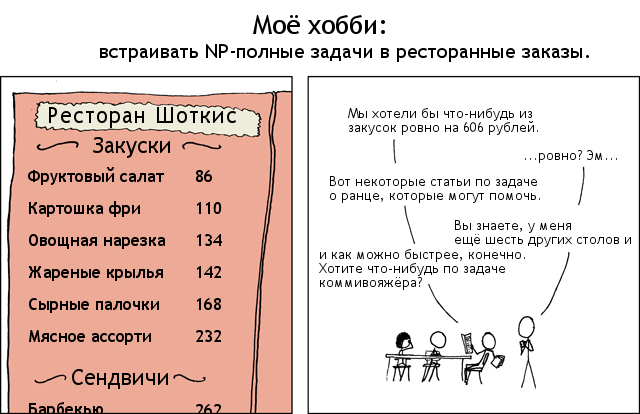

In [49]:
# Так можно добавлять картинки

from IPython.display import Image # вызов из библиотеки определённой функции
Image("официант.png")             # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

# Задача о рюкзаке.

Решите задачу о рюкзаке методом динамического программирования.

Естественно важно правильно выбрать подзадачи. В данном случае есть два естественных способа: рассмотреть рюкзак меньшей ёмкости или же меньшее число предметов. 

Для того чтобы понять, какой подход действительно работает, обычно приходится немного поэкспериментировать.

In [ ]:
things={}
num=int(input())
for i in range(num):
    itemdata=input('Название вес стоимость ').split()
    things.update({itemdata[0]:(int(itemdata[1]),int(itemdata[2]))})
print(things)
lim=int(input('Емкость сумки '))
def lst_weight_cost(items):
    weight=[items[item][0] for item in items]
    cost=[items[item][1] for item in items]
    return weight, cost
def memoisation(things, lim):
    weight, cost=lst_weight_cost(things)
    n=len(things)
    memtable=[[0 for j in range(lim+1)] for i in range(n+1)]
    for i in range(n+1):
        for j in range(lim+1):
            if i==0 or j==0:
                memtable[i][j]=0
            elif weight[i-1]<=j:
                memtable[i][j]=max(cost[i-1]+memtable[i-1][j-weight[i-1]],memtable[i-1][j])
            else:
                memtable[i][j]=memtable[i-1][j]
    return memtable, weight, cost
def itemstaken(things,lim):
    memtable, weight, cost=memoisation(things,lim)
    n=len(things)
    res=memtable[n][lim]
    a=lim
    lst_items=[]
    for i in range(n,0,-1):
        if res<=0:
            break
        if res==memtable[i-1][a]:
            continue
        else:
            lst_items.append((weight[i-1],cost[i-1]))
            res-=cost[i-1]
            a-=weight[i-1]
    picked=[]
    for i in lst_items:
        for key,value in things.items():
            if value==i:
                picked.append(key)
    return picked
bag=itemstaken(things,lim)
print(bag)

# Задача коммивояжёра.

Коммивояжёр должен посетить по разу каждый город из большого списка и вернуться в свой родной город. Он знает расстояния между всеми парами городов. В каком порядке лучше всего посещать города, чтобы минимизировать пройденное расстояние?

Если перебирать все маршруты (их `(n - 1)`!), потребуется время $O(n!)$ (вычисление длины маршрута производится за время $O(n)$). Однако динамическое программирование позволяет решить эту задачу быстрее (хоть и не слишком).

При использовании динамического программирования, поскольку мы ищем маршрут, естественной подзадачей является нахождение начальной части маршрута. Предположим, мы вышли из города `1`, посетили несколько городов и сейчас находимся в городе `j`. Существенной информацией об этом частичном маршруте является то, где мы находимся (`j`), а также те города, где мы уже побывали (чтобы не идти туда второй раз). Это и приводит нас к необходимой подзадаче.

Всего есть не более $2^nn$ подзадач, и решение для каждой из них находится за линейное время. Поэтому общее время работы есть $O(n^22^n)$.

In [21]:
from __future__ import annotations
from typing import Dict, List

# для проверки аннотаций использовать 'python -m mypy <файл>.py'

def tsp_solver(weights: Dict[int, Dict[int, int]]):  # weights[i][j] - вес ребра (i, j)
    amount_of_cities = len(weights)
    routes: Dict[List[int]] = dict()
    prev: Dict[List[int]] = dict()
    routes[0] = [0]
    prev[0] = [0]
    for length in range(1, amount_of_cities):
        routes[length] = float('inf')
        for j in range(1, amount_of_cities):
            if j in prev:
                continue
            if j not in weights[prev[length - 1]].keys():  # если не существует ребра (i, j), где i - последнее
                                                           # добавленное в prev ребро для данных шагов
                continue
            if routes[length] < routes[length - 1] + weights[prev[length - 1]][j]:
                routes[length] = routes[length - 1] + weights[prev[length - 1]][j]
                prev = j
    return routes[amount_of_cities - 1], prev
    
print(tsp_solver({0: {1: 3}, 1: {0: 3}}))

TypeError: unhashable type: 'list'

In [ ]:
def next_permutation(L):
    n = len(L)
    i = n - 2
    while i >= 0 and L[i] >= L[i + 1]:
        i -= 1
    if i == -1:
        return False
    j = i + 1
    while j < n and L[j] > L[i]:
        j += 1
    j -= 1
    L[i], L[j] = L[j], L[i]
    left = i + 1
    right = n - 1
    while left < right:
        L[left], L[right] = L[right], L[left]
        left += 1
        right -= 1
    return True


def travelling_salesman_problem(graph_cost, nrv, start):
    vertices = []
    for i in range(int(nrv)):
        vertices.append(i)
    min_path = float("inf")
    while True:
        current_pathweight = 0
        k = start
        for vertex in vertices:
            if (k, vertex) in graph_cost.keys():
                current_pathweight += graph_cost[(k, vertex)]
                k = vertex
            elif k == vertex:
                continue
            else:
                current_pathweight = float("inf")
        if (k, start) in graph_cost.keys():
            current_pathweight += graph_cost[(k, start)]
        else:
            current_pathweight = float("inf")
        min_path = min(min_path, current_pathweight)
        if not next_permutation(vertices):
            break
    return min_path

def load_from_file():
    filename = input("Filename: ")
    f = open(filename, 'r')
    nrv = f.readline().split()[0]
    costs = {}
    for line in f:
        x, y, cost = map(int, line.split())
        costs[(x, y)] = cost
    f.close()
    return nrv, costs


nrv, costs = load_from_file()
tsp = travelling_salesman_problem(costs, nrv, 0)
if tsp >= float("inf"):
    print("Нет циклов со всеми вершинами.")
else:
    print("Минимальная стоимость:", tsp)